## This Script has code for Running the BICA and the final BIMAN model

Following files are assumed present:
1. Bot data content
2. Non-Bot data content
3. Result of BIN 
4. Result of BIM

In [14]:
library(data.table)
library(randomForest)
library(AUC)
library(plotmo)


Loading required package: Formula
Loading required package: plotrix
Loading required package: TeachingDemos


In [ ]:
# Bot Data Content
botdata = fread('/da4_data/play/botDetection/bot_Info.csv.gz', header = T)

In [6]:
str(botdata)

Classes 'data.table' and 'data.frame':	13150 obs. of  19 variables:
 $ Author                : chr  "010011110110000101101011 <bot@oakmade.com>" "0asa <vince.bot@gmail.com>" "0q0.eu Team <bot@0q0.eu>" "0x48piraj [BOT] <31832371+5p1d3r@users.noreply.github.com>" ...
 $ No.Commit             : int  1 91 5 20 3 1 337 2 34 4 ...
 $ Days.Active           : int  1 381 1 1 1 1 159 3 790 1 ...
 $ Avg.Commit.pYear      : num  1 45.5 5 20 3 ...
 $ Median.Commit.pYear   : num  1 45.5 5 20 3 ...
 $ Activity.Hours        : int  1 15 4 2 2 1 22 2 7 2 ...
 $ Spike.Hours           : int  1 2 4 2 2 1 8 2 1 1 ...
 $ Circ.Variance.Hour    : num  0 3.1213 0.1892 0.0201 0.2612 ...
 $ Tot.uniq.FilesChanged : int  1 108 91 3 83 1 7151 1 5 2 ...
 $ Tot.FilesChanged      : int  1 210 97 20 83 1 9140 2 34 4 ...
 $ Uniq.File.Exten       : int  1 29 3 3 31 1 240 1 2 2 ...
 $ Avg.File.pCommit      : num  1 2.31 19.4 1 27.67 ...
 $ Std.File.pCommit      : num  0 2.04 38.91 0 46.19 ...
 $ No.Timezones          : int

In [7]:
# Bot Data Content
nonbotdata = fread('/da4_data/play/botDetection/non_bot_Info.csv.gz', header = T)
str(nonbotdata)

Classes 'data.table' and 'data.frame':	13150 obs. of  19 variables:
 $ Author                : chr  "adiel <adam@adamdiel.com>" "YannDoy <doy.yann@hotmail.com>" "irvincito <isc.irving.rosales@gmail.com>" "Jesper Corba <jesper@discworld.abf.nl>" ...
 $ No.Commit             : int  6 43 1 2 87 1 1 1 96 1 ...
 $ Days.Active           : int  5 1002 1 1 1425 1 1 1 1732 1 ...
 $ Avg.Commit.pYear      : num  6 14.3 1 2 29 ...
 $ Median.Commit.pYear   : num  6 2 1 2 7 1 1 1 11 1 ...
 $ Activity.Hours        : int  2 6 1 1 17 1 1 1 18 1 ...
 $ Spike.Hours           : int  2 2 1 1 4 1 1 1 4 1 ...
 $ Circ.Variance.Hour    : num  1.231 0.561 0 0 3.808 ...
 $ Tot.uniq.FilesChanged : int  15 19 18 2 50 1 2 31 304 1 ...
 $ Tot.FilesChanged      : int  17 69 18 2 179 1 2 31 395 1 ...
 $ Uniq.File.Exten       : int  10 7 12 2 11 1 2 11 59 1 ...
 $ Avg.File.pCommit      : num  2.83 1.6 0 1 2.06 ...
 $ Std.File.pCommit      : num  2.71 1.26 0 0 1.79 ...
 $ No.Timezones          : int  1 2 1 1 2 1 1 1 3 1

In [8]:
botdata$isBot = 1
nonbotdata$isBot = 0

In [9]:
#Combine Data
alldata = rbind(botdata, nonbotdata)
all.author = alldata$Author
alldata$Author = NULL
alldata$isBot = factor(alldata$isBot)
summary(alldata)

   No.Commit          Days.Active      Avg.Commit.pYear   Median.Commit.pYear
 Min.   :      1.0   Min.   :    1.0   Min.   :     1.0   Min.   :     1.0   
 1st Qu.:      1.0   1st Qu.:    1.0   1st Qu.:     1.0   1st Qu.:     1.0   
 Median :      3.0   Median :    2.0   Median :     3.0   Median :     3.0   
 Mean   :    528.2   Mean   :  185.1   Mean   :   159.0   Mean   :   152.4   
 3rd Qu.:     17.0   3rd Qu.:  143.0   3rd Qu.:    11.5   3rd Qu.:    11.0   
 Max.   :2463758.0   Max.   :24856.0   Max.   :615939.5   Max.   :701464.0   
 Activity.Hours    Spike.Hours     Circ.Variance.Hour Tot.uniq.FilesChanged
 Min.   : 1.000   Min.   : 0.000   Min.   : 0.0000    Min.   :      0      
 1st Qu.: 1.000   1st Qu.: 1.000   1st Qu.: 0.0000    1st Qu.:      1      
 Median : 2.000   Median : 1.000   Median : 0.0000    Median :     10      
 Mean   : 5.017   Mean   : 2.408   Mean   : 0.7988    Mean   :   1376      
 3rd Qu.: 7.000   3rd Qu.: 3.000   3rd Qu.: 1.2313    3rd Qu.:     88     

In [ ]:
# Creating data for Random Forest Model: 70-30 ration for Train and Test set
ind = 1:nrow(alldata)
indTRAIN = sample(ind,round(0.7*length(ind)))
indTEST <- ind[-indTRAIN]
isBot = alldata$isBot
alldata$isBot = NULL

In [11]:
# Subset the data based on previous iterations to get optimal result
alldata.sub = alldata[,c(10,9,12,16,11,17)]

[1] 0.8957038

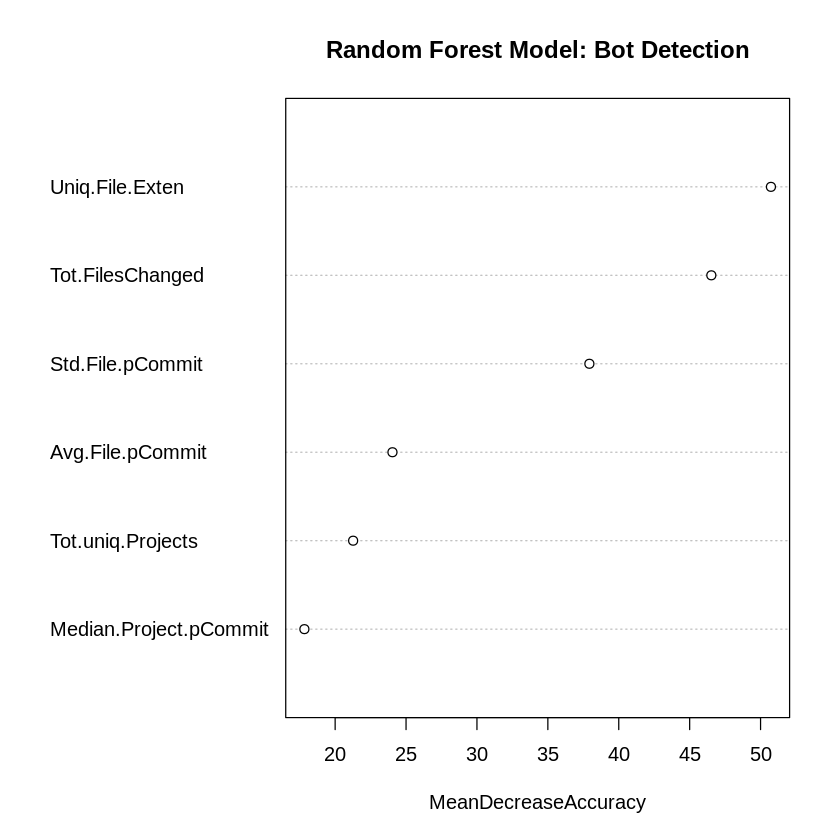

In [30]:
set.seed(10)
BICA <- randomForest(x=alldata.sub[indTRAIN,],
                   y=isBot[indTRAIN], ntree=100, importance=T)
pred <- predict(BICA, alldata.sub[indTEST,], type='prob')[,2]
auc(roc(pred,isBot[indTEST]))
# auc(accuracy(pred,isBot[indTEST]))
varImpPlot(BICA, type=1, main= 'Random Forest Model: Bot Detection')

In [31]:
# Saving the Random Forest Model
save(BICA, file='BICA_model.Rdata')

calculating apartdep for Uniq.File.Exten 
calculating apartdep for Tot.FilesChanged 
calculating apartdep for Std.File.pCommit 
calculating apartdep for Tot.uniq.Projects 
calculating apartdep for Avg.File.pCommit 
calculating apartdep for Median.Project.pCommit 


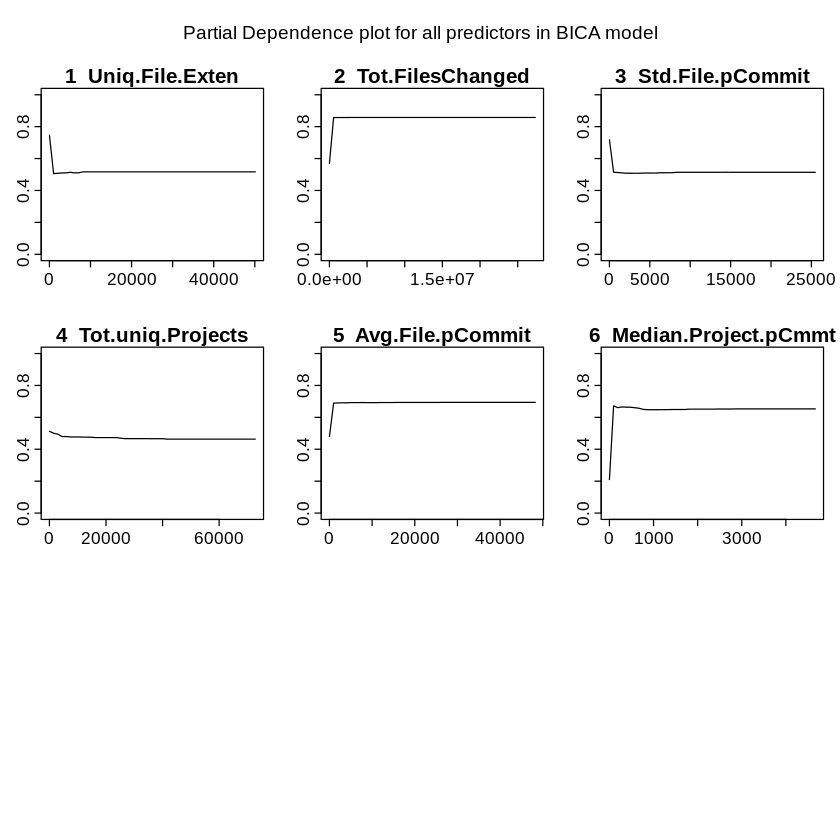

In [33]:
plotmo(BICA, type='prob', pmethod='apartdep', degree2 = F, persp.ticktype="detailed", persp.nticks=3, 
       caption = 'Partial Dependence plot for all predictors in BICA model', cex = 1.3)

## This concludes the BICA Training part
## Example of using BICA to predict bots is shown below

In [17]:
ftestdata = fread('/da4_data/play/botDetection/test_Info_paper.csv.gz', header = T)
auth = ftestdata$Author
ftestdata$Author = NULL


In [18]:
# Predicting Class
pcl = predict(rfModel2, ftestdata, type='class')
df.paper.c = data.frame(auth, pcl)
head(df.paper.c)

auth,pcl
dependabot[bot] <support@dependabot.com>,1
greenkeeper <felixhennigfh@gmail.com>,0
Greenkeeper <support@greenkeeper.io>,1
greenkeeper.io <support@greenkeeper.io>,1
greenkeeper-keeper <nodaguti+keeper@gmail.com>,1
greenkeeper <greenkeeper@users.noreply.github.com>,0


In [19]:
# Predicting Probability
 p = predict(rfModel2, ftestdata, type='prob')[,2]
df.paper.p = data.frame(auth, p)
head(df.paper.p)

auth,p
dependabot[bot] <support@dependabot.com>,0.93
greenkeeper <felixhennigfh@gmail.com>,0.42
Greenkeeper <support@greenkeeper.io>,0.85
greenkeeper.io <support@greenkeeper.io>,0.89
greenkeeper-keeper <nodaguti+keeper@gmail.com>,0.90
greenkeeper <greenkeeper@users.noreply.github.com>,0.26


## Training the Ensemble Model (BIMAN) is similar:

Generate data frame for test samples with their BICA probability (`p`), 1-BIM ratio (`ratio`), and name prediction from BIN (`name`)

In [ ]:
# Generate bot data for BIMAN training - Either run this or use example data from the next cell
bto = fread('/da4_data/play/botDetection/bot_template.out', header =F) # BIM o/p for bots
colnames(bto) = c('auth','commits', 'templates', 'ratio')
bot_data_all = merge(df.paper.p, bto) # df.paper.p: BICA probability for bots
bot_data_all =  bot_data_all[,c(1,2,5)]
bot_data_all$ratio = 1 - bot_data_all$ratio
bot_data_all$name = 1 # BIN o/p for bots: set to 1 for demonstration


In [25]:
### THIS IS AN EXAMPLE CELL - DO NOT RUN IF YOU RAN THE CELL ABOVE
# Showing pre-calculated data for example, similar structure for non bot data
load('bot_data_all.Rdata')
str(bot_data_all)

'data.frame':	67 obs. of  5 variables:
 $ auth : Factor w/ 61 levels "Alba bot <deploybot@nanoporetech.com>",..: 1 2 4 5 6 7 8 9 32 33 ...
 $ p    : num  0.97 0.89 0.57 1 1 1 0.87 0.22 0.99 1 ...
 $ ratio: num  0 0 0.833 0 1 ...
 $ name : int  1 1 1 1 1 1 1 1 1 1 ...
 $ BOT  : int  1 1 1 1 1 1 1 1 1 1 ...


## You need to run similar steps for non-bots as well

In [ ]:
set.seed(25)
nb.aa = sample(13150,67)
df.nb = nonbotdata[nb.aa,]
nbaa = df.nb$Author
df.nb$Author = NULL
p = predict(BICA, df.nb, type='prob')[,2]
df.nbp = data.frame(nbaa, p)
colnames(df.nbp) = c('auth', 'p')


In [ ]:
nbto = fread('/da4_data/play/botDetection/nonbot_template.out', header =F)
colnames(nbto) = c('auth','commits', 'templates', 'ratio')

df.nba = merge(df.nbp, nbto)
df.nba =  df.nba[,c(1,2,5)]
df.nba$ratio = 1 - df.nba$ratio
df.nba$name = 0

In [ ]:
#Merge bot & non-bot data
df.nba$BOT = 0
df.b.all$BOT = 1
df.f.all = data.frame(rbind(df.b.all, df.nba))
df.f.all$BOT = factor(df.f.all$BOT)

df.f.all$name = factor(df.f.all$name)
ta.f = df.f.all$auth
df.f.all$auth = NULL

BOT = df.f.all$BOT
df.f.all$BOT = NULL

In [ ]:
# Training the BIMAN model:
set.seed(100)
ind = 1:nrow(df.f.all)
indTRAIN = sample(ind,round(0.8*length(ind)))
indTEST <- ind[-indTRAIN]

rfModel <- randomForest(x=data_all_biman[indTRAIN,],  y=BOT[indTRAIN], ntree=1000, importance=T) 

In [26]:
# Loading pre-trained BIMAN model - EITHER RUN THE TRAINING OR USE PRE_TRAINED DATA
load('ensemble.Rdata')

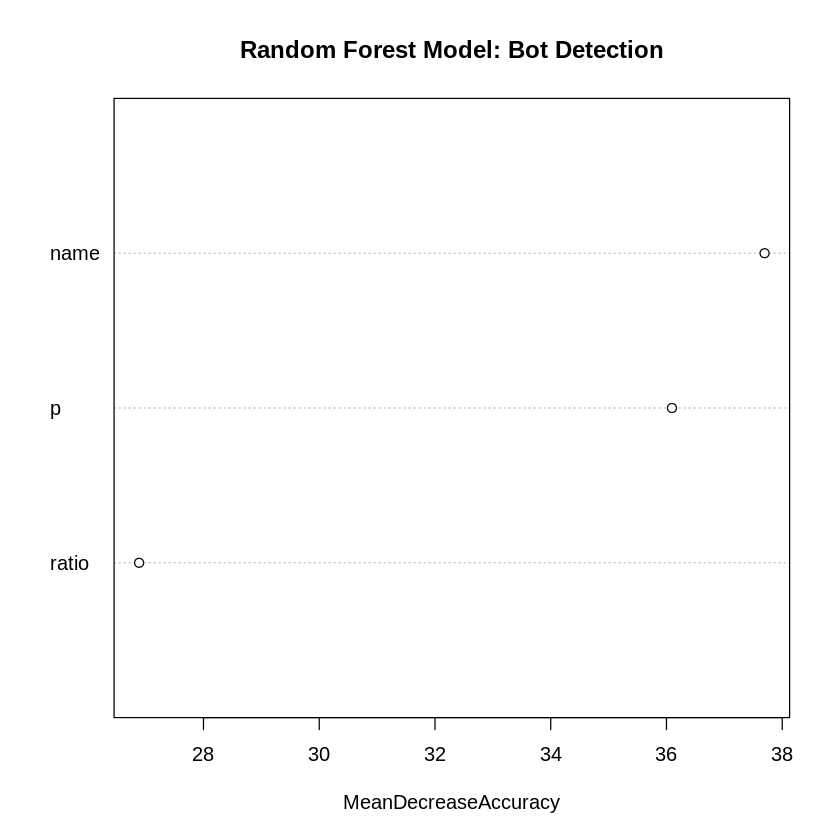

In [29]:
varImpPlot(rfModel, type=1, main= 'Random Forest Model: Bot Detection')

## Name of the BICA model: BICA
## Name of ensemble BIMAN model: rfModel